In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("data/scimagojr_country_rank.csv")

df.head()

,Unnamed: 0,Rank,Country,Region,Documents,Citable documents,Citations,Self-citations,Citations per document,H index,Year
0,0,1,China,Asiatic Region,808780,790175,15659002,9811443,19.36,1455,2020
1,1,2,United States,Northern America,742757,634028,14655795,5097358,19.73,3213,2020
2,2,3,United Kingdom,Western Europe,238119,197620,5329400,993232,22.38,2048,2020
3,3,4,India,Asiatic Region,222537,196605,2917582,1081036,13.11,925,2020
4,4,5,Germany,Western Europe,200231,178280,3897268,801153,19.46,1797,2020


In [4]:
# Create country × year dataframe (wide format)
df_period = df[df['Year'].between(2020, 2024)]

self_cit_df = (
    df_period
    .pivot_table(
        index='Country',
        columns='Year',
        values='Self-citations',
        aggfunc='sum'
    )
    .sort_index()
)

# Rename columns for clarity
self_cit_df.columns = [f"Self_citations_{year}" for year in self_cit_df.columns]

In [5]:
# Handle missing values
df = df.fillna(df.median(numeric_only=True))

# Normalize by 2020
norm_df = self_cit_df.div(self_cit_df.iloc[:, 0], axis=0)

In [6]:
# Standardize (cluster by pattern, not magnitude)
scaler = StandardScaler()
# X_scaled = scaler.fit_transform(self_cit_df)
X_scaled = scaler.fit_transform(norm_df)

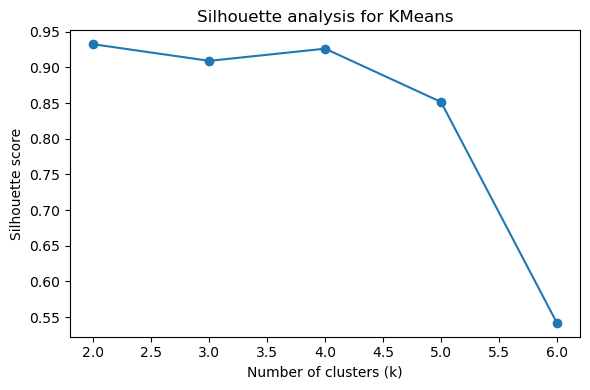

In [7]:
# Silhouette analysis for different k
silhouette_scores = {}

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores[k] = score

plt.figure(figsize=(6, 4))
plt.plot(
    list(silhouette_scores.keys()),
    list(silhouette_scores.values()),
    marker='o'
)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis for KMeans')
plt.tight_layout()
plt.show()

In [8]:
# KMeans clustering on temporal patterns
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# self_cit_df['Cluster'] = clusters
norm_df['Cluster'] = clusters

In [9]:
# Compute mean time trajectory per cluster
# years = [c for c in self_cit_df.columns if c.startswith("Self_citations_")]
# cluster_means = (self_cit_df.groupby('Cluster')[years].mean())

years = [c for c in norm_df.columns if c.startswith("Self_citations_")]
cluster_means = (norm_df.groupby('Cluster')[years].mean())

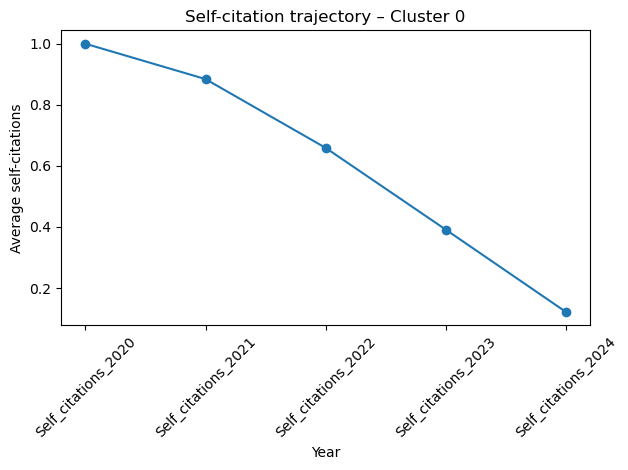

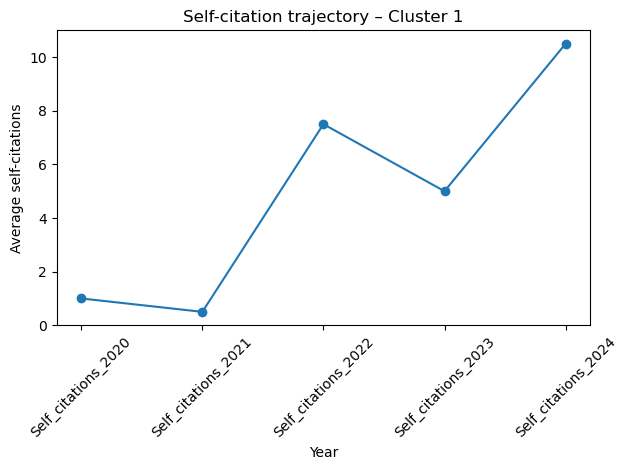

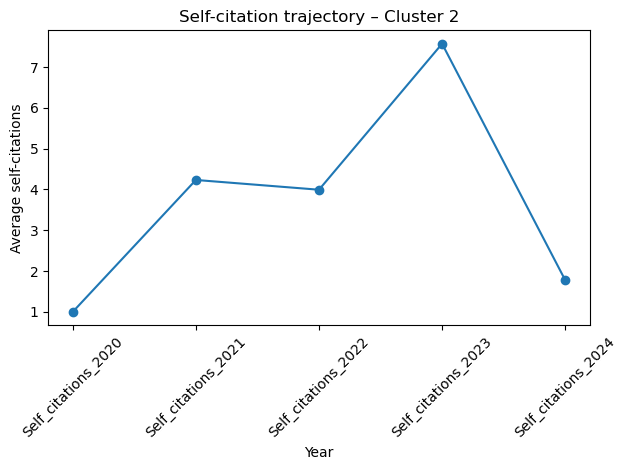

In [10]:
# Visualize cluster time trajectories
for cluster_id, row in cluster_means.iterrows():
    plt.figure()
    plt.plot(years, row.values, marker='o')
    
    plt.xlabel("Year")
    plt.ylabel("Average self-citations")
    plt.title(f"Self-citation trajectory – Cluster {cluster_id}")
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [11]:
# Interpret cluster centroids as patterns
# centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=self_cit_df.columns[:-1])
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=norm_df.columns[:-1])

centroids

,Self_citations_2020,Self_citations_2021,Self_citations_2022,Self_citations_2023,Self_citations_2024
0,1.0,0.884224,0.659027,0.391368,0.121910
1,1.0,0.500000,7.500000,5.000000,10.500000
2,1.0,4.232418,3.993223,7.571245,1.778571


In [12]:
# Define abnormal growth indicators

# Total growth factor
# self_cit_df['Growth'] = self_cit_df['Self_citations_2024'] - 1
norm_df['Growth'] = norm_df['Self_citations_2024'] - 1

# Trajectory volatility
# year_cols = [c for c in self_cit_df.columns if "Self_citations_" in c]
# self_cit_df['Volatility'] = self_cit_df[year_cols].std(axis=1)
year_cols = [c for c in norm_df.columns if "Self_citations_" in c]
norm_df['Volatility'] = norm_df[year_cols].std(axis=1)

In [13]:
# Flag statistical outliers (IQR method)
# Q1 = self_cit_df['Growth'].quantile(0.25)
# Q3 = self_cit_df['Growth'].quantile(0.75)
Q1 = norm_df['Growth'].quantile(0.25)
Q3 = norm_df['Growth'].quantile(0.75)
IQR = Q3 - Q1
growth_threshold = Q3 + 1.5 * IQR

# Q1_v = self_cit_df['Volatility'].quantile(0.25)
# Q3_v = self_cit_df['Volatility'].quantile(0.75)
Q1_v = norm_df['Volatility'].quantile(0.25)
Q3_v = norm_df['Volatility'].quantile(0.75)
IQR_v = Q3_v - Q1_v
volatility_threshold = Q3_v + 1.5 * IQR_v

In [14]:
# Final abnormality flag
# self_cit_df['Abnormal_growth'] = (
#     (self_cit_df['Growth'] > growth_threshold) |
#     (self_cit_df['Volatility'] > volatility_threshold)
# )
norm_df['Abnormal_growth'] = (
    (norm_df['Growth'] > growth_threshold) |
    (norm_df['Volatility'] > volatility_threshold)
)

In [15]:
# Extract flagged countries
# abnormal_countries = self_cit_df[self_cit_df['Abnormal_growth']].sort_values(['Growth', 'Volatility'], ascending=False)
abnormal_countries = norm_df[norm_df['Abnormal_growth']].sort_values(['Growth', 'Volatility'], ascending=False)

abnormal_countries[['Growth', 'Volatility']].head(10)

,Growth,Volatility
Country,,
Montserrat,9.500000,4.263215
Comoros,2.400000,6.582401
Gibraltar,0.714286,3.855291
Turkmenistan,0.000000,2.021336
Antigua and Barbuda,0.000000,1.693123
Somalia,0.000000,0.729852
Central African Republic,-0.382979,0.362327
Saint Helena,-0.500000,0.651920
Afghanistan,-0.621212,0.617530


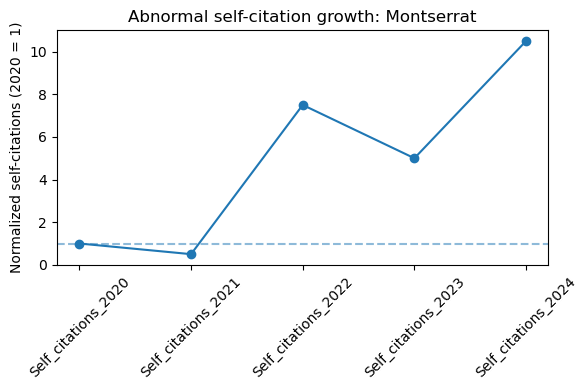

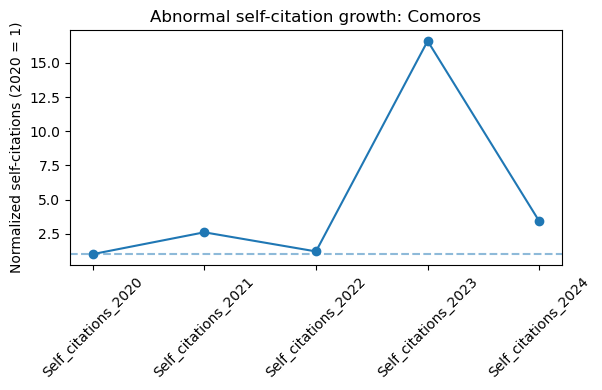

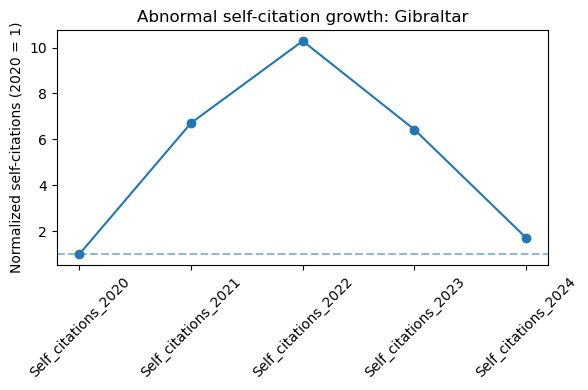

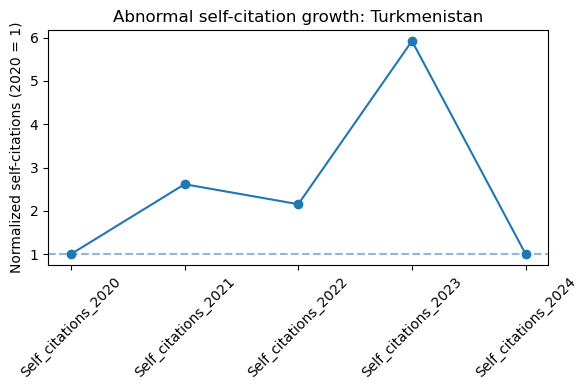

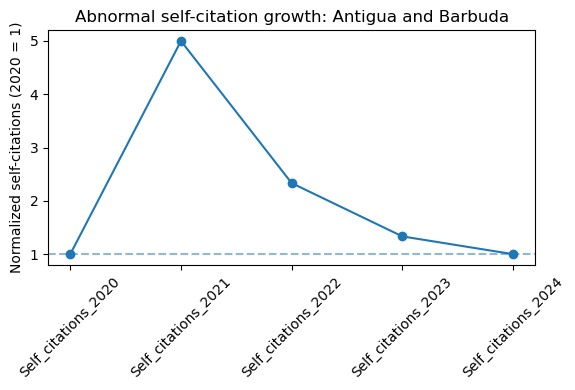

In [16]:
# Visualize abnormal trajectories
for country, row in abnormal_countries[year_cols].head(5).iterrows():
    plt.figure(figsize=(6, 4))
    plt.plot(year_cols, row.values, marker='o')
    plt.axhline(1.0, linestyle='--', alpha=0.5)
    plt.title(f"Abnormal self-citation growth: {country}")
    plt.ylabel("Normalized self-citations (2020 = 1)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [17]:
# Automatic labeling
def label_country(row):
    if row['Volatility'] > Q3_v:
        return 'Volatile'
    elif row['Growth'] > Q3:
        return 'Inflated'
    else:
        return 'Stable'

# self_cit_df['Behavior_Label'] = self_cit_df.apply(label_country, axis=1)
norm_df['Behavior_Label'] = norm_df.apply(label_country, axis=1)

In [18]:
# Inspect label distribution
# self_cit_df['Behavior_Label'].value_counts()
norm_df['Behavior_Label'].value_counts()

Behavior_Label
Stable      125
Volatile     55
Inflated     40
Name: count, dtype: int64

In [19]:
# Validate via cluster consistency
# pd.crosstab(self_cit_df['Behavior_Label'], self_cit_df['Cluster'])
pd.crosstab(norm_df['Behavior_Label'], norm_df['Cluster'])

Cluster,0,1,2
Behavior_Label,,,
Inflated,40,0,0
Stable,125,0,0
Volatile,50,1,4


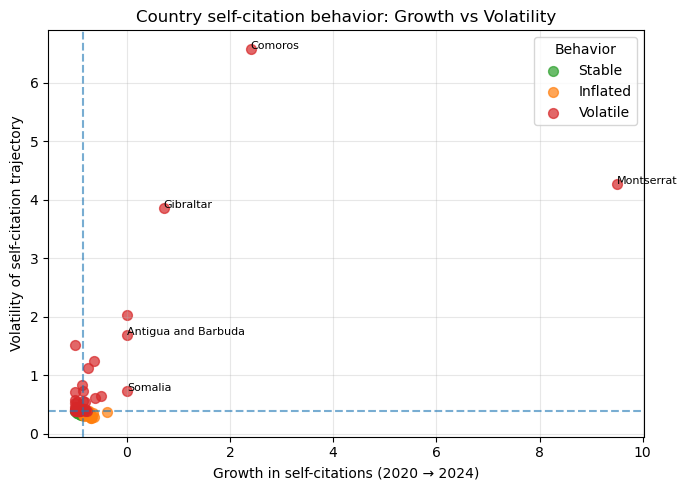

In [20]:
# Define colors for behavior labels
color_map = {
    'Stable': '#2ca02c',     # green
    'Inflated': '#ff7f0e',   # orange
    'Volatile': '#d62728'    # red
}

plt.figure(figsize=(7, 5))

for label, color in color_map.items():
    subset = norm_df[norm_df['Behavior_Label'] == label]
    plt.scatter(
        subset['Growth'],
        subset['Volatility'],
        label=label,
        alpha=0.7,
        s=50,
        color=color
    )

plt.xlabel("Growth in self-citations (2020 → 2024)")
plt.ylabel("Volatility of self-citation trajectory")
plt.title("Country self-citation behavior: Growth vs Volatility")

plt.axvline(Q3, linestyle='--', alpha=0.6)
plt.axhline(Q3_v, linestyle='--', alpha=0.6)

for country, row in norm_df.sort_values('Growth', ascending=False).head(5).iterrows():
    plt.text(row['Growth'], row['Volatility'], country, fontsize=8)

plt.legend(title="Behavior")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


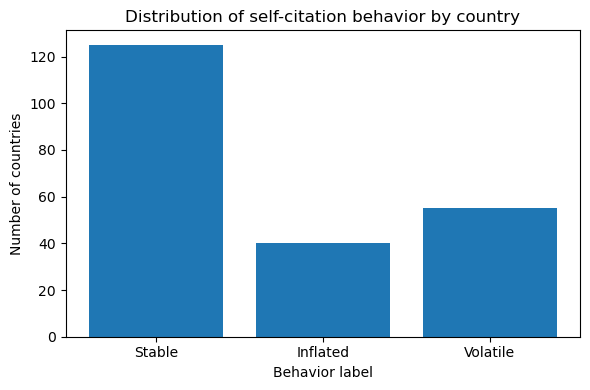

In [21]:
order = ['Stable', 'Inflated', 'Volatile']
label_counts = norm_df['Behavior_Label'].value_counts()
label_counts = label_counts.reindex(order)

plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel("Behavior label")
plt.ylabel("Number of countries")
plt.title("Distribution of self-citation behavior by country")
plt.tight_layout()
plt.show()